In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, classification_report
from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
fer_directory = 'data/FER2013'
ck_directory = 'data/CK+'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tensorflow version: 2.10.1
Num GPUs Available:  1


In [2]:
def plot_model_training(history):
    # Plot training & validation accuracy values
    plt.figure(facecolor='white')
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy', fontsize=20)
    plt.ylabel('Accuracy', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.figure(facecolor='white')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss', fontsize=20)
    plt.ylabel('Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def calculate_model_metrics(y_true, y_pred, classes):
    # Calculate metrics
    print(classification_report(y_true, np.argmax(y_pred, axis=1), target_names=classes))

    # Calculate Precision, Recall, F1 score
    precision, recall, fscore, support = precision_recall_fscore_support(y_true, np.argmax(y_pred, axis=1), average='macro')
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", fscore)
    
    return precision, recall, fscore

def plot_confusion_matrix(y_true, y_pred, classes):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.show()

<h2>Pre processing with data augmentation</h2>

In [2]:
# Initialise generator with rescale factor 1./255
train_gen = ImageDataGenerator(rescale=1./255, rotation_range=10,  zoom_range=0.1, horizontal_flip=True)
test_gen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

# Preprocess training set
train_generator = train_gen.flow_from_directory(
    fer_directory + '/train',
    target_size=(48,48),
    batch_size=128,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True
)

validation_generator = test_gen.flow_from_directory(
    fer_directory + '/test',
    target_size=(48,48),
    batch_size=128,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Preprocess test set
# False shuffle so classification dont get mixed
test_generator = test_gen.flow_from_directory(
    fer_directory + '/test',
    target_size=(48,48),
    batch_size=128,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training', # Doesnt really matter just splitting test data into 50 50
    shuffle=False
)

Found 28709 images belonging to 7 classes.
Found 3587 images belonging to 7 classes.
Found 3591 images belonging to 7 classes.


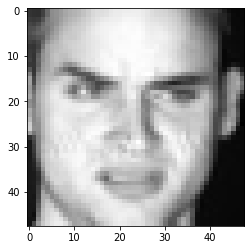

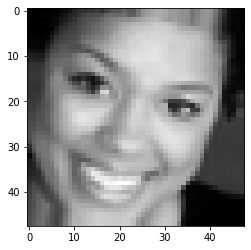

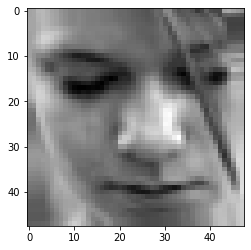

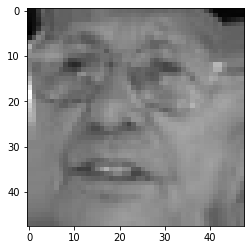

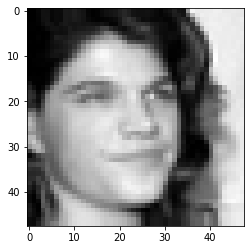

[0. 1. 0. 0. 0. 0. 0.]


In [4]:
# Display Augmented Images
x, y = train_generator.next()
for i in range(0, 5):
    image = x[i]
    plt.imshow(image.reshape(48, 48), cmap='gray')
    plt.show()
print(y[0])

In [4]:
# Get steps per epoch
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

# Get classes and y labels
classes = list(test_generator.class_indices.keys())
y_true = test_generator.classes

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00001, mode='max', verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, restore_best_weights=True)

<h1>3 CNN Layers Model Run</h1>

In [15]:
# Define model
first_model = Sequential()

# 1st convolution layer
first_model.add(Conv2D(64, (3,3), padding='same', input_shape=(48,48,1)))
first_model.add(BatchNormalization())
first_model.add(Activation('relu'))
first_model.add(MaxPooling2D(pool_size=(2,2)))
first_model.add(Dropout(0.25))

# 2nd convolution layer
first_model.add(Conv2D(128, (5,5), padding='same'))
first_model.add(BatchNormalization())
first_model.add(Activation('relu'))
first_model.add(MaxPooling2D(pool_size=(2,2)))
first_model.add(Dropout(0.25))

# 3rd convolution layer
first_model.add(Conv2D(512, (3,3), padding='same'))
first_model.add(BatchNormalization())
first_model.add(Activation('relu'))
first_model.add(MaxPooling2D(pool_size=(2,2)))
first_model.add(Dropout(0.25))

# Flatten and feed into dense layer
first_model.add(Flatten())
first_model.add(Dense(256))
first_model.add(BatchNormalization())
first_model.add(Activation('relu'))
first_model.add(Dropout(0.25))

# Output layer
first_model.add(Dense(7, activation='softmax'))

# Compile model
first_model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
first_model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_25 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_34 (Conv2D)          (None, 24, 24, 128)      

In [11]:
# Plots image
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
# Image('model.png',width=400, height=200)

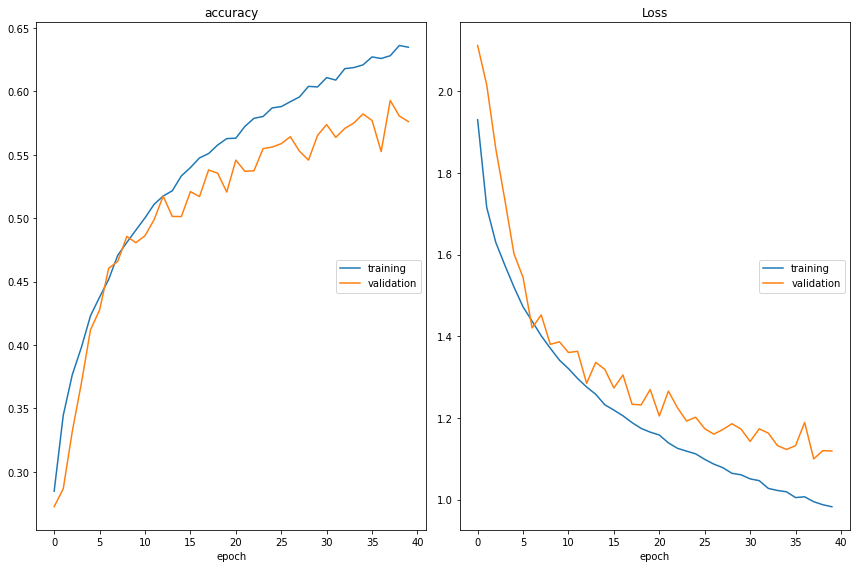

accuracy
	training         	 (min:    0.285, max:    0.636, cur:    0.635)
	validation       	 (min:    0.272, max:    0.593, cur:    0.576)
Loss
	training         	 (min:    0.982, max:    1.931, cur:    0.982)
	validation       	 (min:    1.100, max:    2.113, cur:    1.119)
179/179 [==============================] - 26s 143ms/step - loss: 0.9824 - accuracy: 0.6349 - val_loss: 1.1190 - val_accuracy: 0.5762


In [4]:
# Train model
epochs = 40
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

# Save model weights
checkpoint = ModelCheckpoint('weights/model_weights_first.h5', monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)

# Train model
history = first_model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stop, PlotLossesKeras()],
)

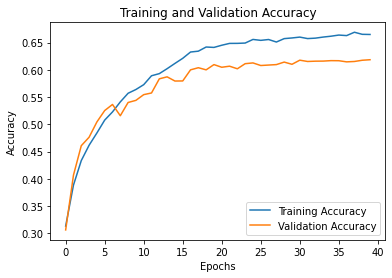

In [ ]:
# Plot training and validation accuracy and loss
plot_model_training(history)

In [16]:
# Test model
first_model.load_weights('weights/model_weights_first.h5')
first_model_accuracy = first_model.evaluate(test_generator)
first_model_y_pred = first_model.predict(test_generator)

29/29 [==============================] - 2s 61ms/step


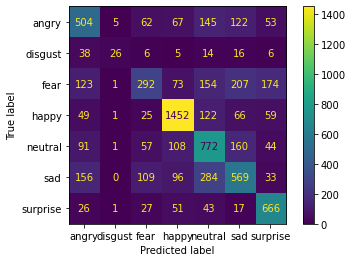

In [17]:
# Plot confusion matrix
cm = confusion_matrix(test_generator.classes, np.argmax(first_model_y_pred, axis=1))
cm_display = ConfusionMatrixDisplay(cm, display_labels=classes)
cm_display.plot()

In [19]:
# Calculate metrics
first_model_precision, first_model_recall, first_model_fscore = calculate_model_metrics(y_true, first_model_y_pred, classes)

              precision    recall  f1-score   support

       angry       0.53      0.53      0.53       479
     disgust       0.78      0.25      0.38        56
        fear       0.56      0.24      0.34       512
       happy       0.78      0.79      0.78       887
     neutral       0.45      0.67      0.54       617
         sad       0.51      0.37      0.43       624
    surprise       0.59      0.84      0.70       416

    accuracy                           0.58      3591
   macro avg       0.60      0.53      0.53      3591
weighted avg       0.59      0.58      0.57      3591

Precision: 0.5982755902121412
Recall: 0.5278365933244664
F1 Score: 0.5270283686563685


<h1>3 CNN Layers Model with hyperparameter optimisation</h1>

In [20]:
# First Model Optimised
# Define model
first_model_optimised = Sequential()

# 1st convolution layer
first_model_optimised.add(Conv2D(64, (3,3), padding='same', input_shape=(48,48,1)))
first_model_optimised.add(BatchNormalization())
first_model_optimised.add(Activation('relu'))
first_model_optimised.add(MaxPooling2D(pool_size=(2,2)))
first_model_optimised.add(Dropout(0.25))

# 2nd convolution layer
first_model_optimised.add(Conv2D(320, (5,5), padding='same'))
first_model_optimised.add(BatchNormalization())
first_model_optimised.add(Activation('relu'))
first_model_optimised.add(MaxPooling2D(pool_size=(2,2)))
first_model_optimised.add(Dropout(0.25))

# 3rd convolution layer
first_model_optimised.add(Conv2D(512, (3,3), padding='same'))
first_model_optimised.add(BatchNormalization())
first_model_optimised.add(Activation('relu'))
first_model_optimised.add(MaxPooling2D(pool_size=(2,2)))
first_model_optimised.add(Dropout(0.25))

# Flatten and feed into dense layer
first_model_optimised.add(Flatten())
first_model_optimised.add(Dense(512))
first_model_optimised.add(BatchNormalization())
first_model_optimised.add(Activation('relu'))
first_model_optimised.add(Dropout(0.3))

# Output layer
first_model_optimised.add(Dense(7, activation='softmax'))

# Compile model
first_model_optimised.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
first_model_optimised.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_29 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_37 (Conv2D)          (None, 24, 24, 320)      

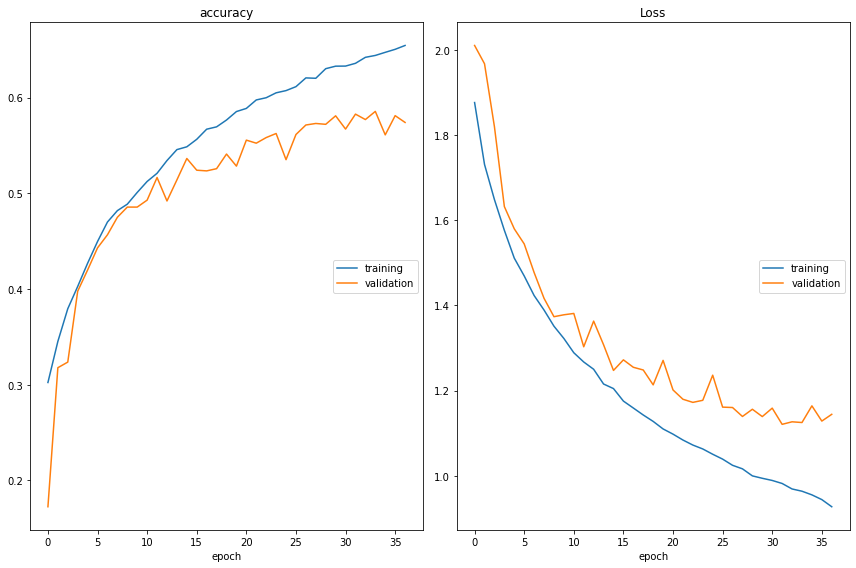

accuracy
	training         	 (min:    0.302, max:    0.654, cur:    0.654)
	validation       	 (min:    0.173, max:    0.586, cur:    0.574)
Loss
	training         	 (min:    0.928, max:    1.876, cur:    0.928)
	validation       	 (min:    1.121, max:    2.010, cur:    1.145)
179/179 [==============================] - 25s 138ms/step - loss: 0.9276 - accuracy: 0.6545 - val_loss: 1.1445 - val_accuracy: 0.5740


In [9]:
# Train model
epochs = 40
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

# Reduce learning rate when a metric has stopped improving
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, mode='auto')

# Stop training when val loss has stopped improving
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Save model weights
checkpoint = ModelCheckpoint('weights/model_weights_first_optimised.h5', monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)

# Train model
history_new_optimised = first_model_optimised.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stop, PlotLossesKeras()],
)

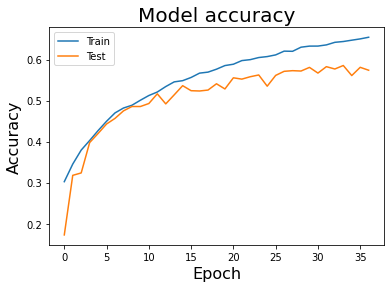

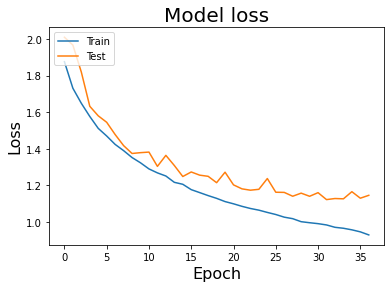

In [10]:
# Plot training and validation accuracy and loss
plot_model_training(history_new_optimised)

In [21]:
# Test model
first_model_optimised.load_weights('weights/model_weights_first_optimised.h5')
first_model_optimised_accuracy = first_model_optimised.evaluate(test_generator)
first_model_optimised_y_pred = first_model_optimised.predict(test_generator)

29/29 [==============================] - 2s 60ms/step


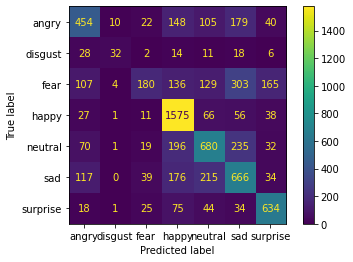

In [12]:
# Plot confusion matrix
cm = plot_confusion_matrix(y_true, first_model_optimised_y_pred, classes)

In [22]:
# Calculate metrics
first_model_optimised_precision, first_model_optimised_recall, first_model_optimised_fscore = calculate_model_metrics(y_true, first_model_optimised_y_pred, classes)

              precision    recall  f1-score   support

       angry       0.55      0.47      0.51       479
     disgust       0.78      0.25      0.38        56
        fear       0.64      0.18      0.28       512
       happy       0.71      0.88      0.78       887
     neutral       0.47      0.66      0.55       617
         sad       0.48      0.42      0.44       624
    surprise       0.65      0.81      0.72       416

    accuracy                           0.59      3591
   macro avg       0.61      0.52      0.52      3591
weighted avg       0.59      0.59      0.56      3591

Precision: 0.6118969358512825
Recall: 0.523303073559033
F1 Score: 0.5240339736252524


<h1>4 CNN Layers Model</h1>

In [23]:
# Reference model
ref_model = Sequential()

ref_model.add(Conv2D(256, (3,3), padding='same', input_shape=(48,48,1), activation='relu'))
ref_model.add(Conv2D(516, (3,3), padding='same', activation='relu'))
ref_model.add(BatchNormalization())
ref_model.add(MaxPooling2D(pool_size=(2,2)))
ref_model.add(Dropout(0.4))

ref_model.add(Conv2D(384, (3,3), padding='same', activation='relu'))
ref_model.add(BatchNormalization())
ref_model.add(MaxPooling2D(pool_size=(2,2)))
ref_model.add(Dropout(0.4))

ref_model.add(Conv2D(192, (3,3), padding='same', activation='relu'))
ref_model.add(BatchNormalization())
ref_model.add(MaxPooling2D(pool_size=(2,2)))
ref_model.add(Dropout(0.4))

ref_model.add(Conv2D(384, (3,3), padding='same', activation='relu'))
ref_model.add(BatchNormalization())
ref_model.add(MaxPooling2D(pool_size=(2,2)))
ref_model.add(Dropout(0.4))

ref_model.add(Flatten())
ref_model.add(Dense(256, activation='relu'))
ref_model.add(BatchNormalization())

ref_model.add(Dropout(0.3))
ref_model.add(Dense(7, activation='softmax'))

ref_model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
ref_model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 48, 48, 256)       2560      
                                                                 
 conv2d_40 (Conv2D)          (None, 48, 48, 516)       1189380   
                                                                 
 batch_normalization_33 (Bat  (None, 48, 48, 516)      2064      
 chNormalization)                                                
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 24, 24, 516)      0         
 g2D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 24, 24, 516)       0         
                                                                 
 conv2d_41 (Conv2D)          (None, 24, 24, 384)      

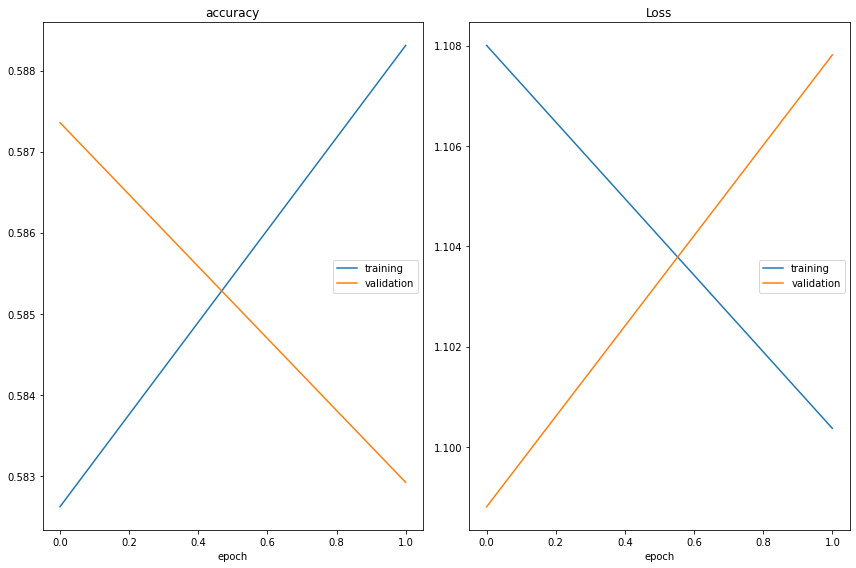

accuracy
	training         	 (min:    0.583, max:    0.588, cur:    0.588)
	validation       	 (min:    0.583, max:    0.587, cur:    0.583)
Loss
	training         	 (min:    1.100, max:    1.108, cur:    1.100)
	validation       	 (min:    1.099, max:    1.108, cur:    1.108)
179/179 [==============================] - 140s 778ms/step - loss: 1.1004 - accuracy: 0.5883 - val_loss: 1.1078 - val_accuracy: 0.5829


In [7]:
# Train model
epochs = 40
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

# Save model weights
checkpoint = ModelCheckpoint('weights/model_weights_ref.h5', monitor='val_accuracy', save_weights_only=True, mode='max', verbose=2)

# Load model weights
ref_model.load_weights('weights/model_weights_ref.h5')
epochs = 2 # last manage to run for 38

# Train model
history_ref_model = ref_model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stop, PlotLossesKeras()],
)

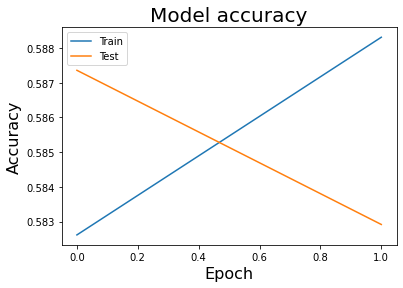

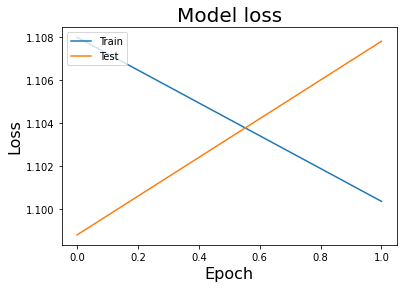

In [8]:
# Plot training and validation accuracy and loss
plot_model_training(history_ref_model)


accuracy
	training         	 (min:    0.180, max:    0.581, cur:    0.581)
	validation       	 (min:    0.251, max:    0.578, cur:    0.578)
Loss
	training         	 (min:    1.106, max:    2.588, cur:    1.106)
	validation       	 (min:    1.112, max:    2.327, cur:    1.112)

In [24]:
# Evaluate Model
ref_model.load_weights('weights/model_weights_ref.h5')
ref_model.evaluate(test_generator)
ref_model_y_pred = ref_model.predict(test_generator, test_generator.n//test_generator.batch_size+1)

29/29 [==============================] - 4s 133ms/step


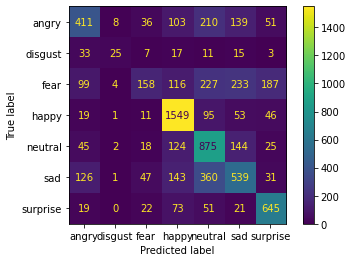

In [24]:
# Confusion Matrix
plot_confusion_matrix(y_true, ref_model_y_pred, classes)

In [25]:
# Calculate metrics
ref_model_precision, ref_model_recall, ref_model_fscore = calculate_model_metrics(y_true, ref_model_y_pred, classes)

              precision    recall  f1-score   support

       angry       0.52      0.50      0.51       479
     disgust       0.88      0.25      0.39        56
        fear       0.57      0.17      0.26       512
       happy       0.75      0.86      0.80       887
     neutral       0.46      0.73      0.56       617
         sad       0.52      0.38      0.44       624
    surprise       0.68      0.82      0.74       416

    accuracy                           0.59      3591
   macro avg       0.63      0.53      0.53      3591
weighted avg       0.60      0.59      0.57      3591

Precision: 0.6250817842965458
Recall: 0.5306283607508331
F1 Score: 0.5304085381763481


<h2>4 CNN Layers with hyper parameters tuned</h2>

In [32]:
# Define new model with optimised parameters
# Reference model
ref_model_optimised = Sequential()

ref_model_optimised.add(Conv2D(256, (3,3), padding='same', input_shape=(48,48,1), activation='relu'))
ref_model_optimised.add(Conv2D(384, (3,3), padding='same', activation='relu'))
ref_model_optimised.add(BatchNormalization())
ref_model_optimised.add(MaxPooling2D(pool_size=(2,2)))
ref_model_optimised.add(Dropout(0.3))

ref_model_optimised.add(Conv2D(320, (3,3), padding='same', activation='relu'))
ref_model_optimised.add(BatchNormalization())
ref_model_optimised.add(MaxPooling2D(pool_size=(2,2)))
ref_model_optimised.add(Dropout(0.3))

ref_model_optimised.add(Conv2D(192, (3,3), padding='same', activation='relu'))
ref_model_optimised.add(BatchNormalization())
ref_model_optimised.add(MaxPooling2D(pool_size=(2,2)))
ref_model_optimised.add(Dropout(0.3))

ref_model_optimised.add(Conv2D(192, (3,3), padding='same', activation='relu'))
ref_model_optimised.add(BatchNormalization())
ref_model_optimised.add(MaxPooling2D(pool_size=(2,2)))
ref_model_optimised.add(Dropout(0.3))

ref_model_optimised.add(Flatten())
ref_model_optimised.add(Dense(352, activation='relu'))
ref_model_optimised.add(BatchNormalization())

ref_model_optimised.add(Dropout(0.1))
ref_model_optimised.add(Dense(7, activation='softmax'))

ref_model_optimised.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
ref_model_optimised.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 48, 48, 256)       2560      
                                                                 
 conv2d_52 (Conv2D)          (None, 48, 48, 384)       885120    
                                                                 
 batch_normalization_44 (Bat  (None, 48, 48, 384)      1536      
 chNormalization)                                                
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 24, 24, 384)      0         
 g2D)                                                            
                                                                 
 dropout_41 (Dropout)        (None, 24, 24, 384)       0         
                                                                 
 conv2d_53 (Conv2D)          (None, 24, 24, 320)      

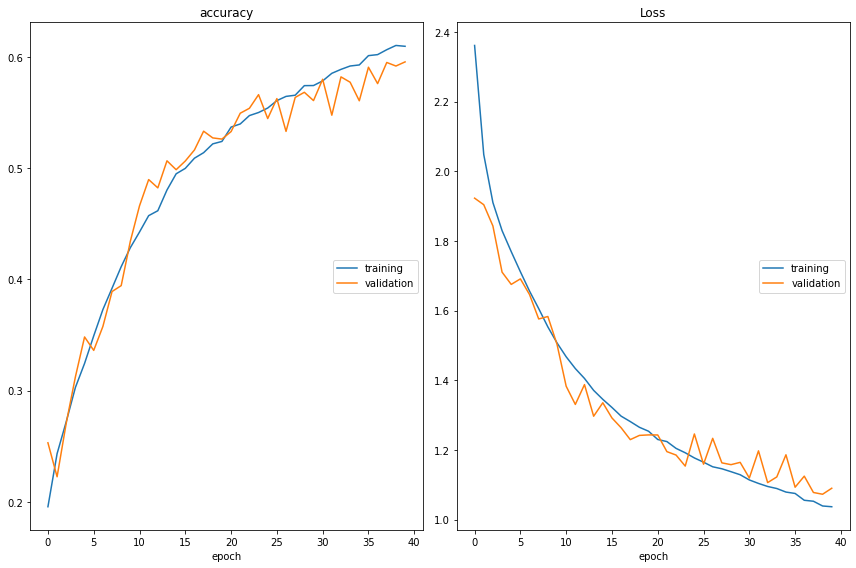

accuracy
	training         	 (min:    0.196, max:    0.610, cur:    0.610)
	validation       	 (min:    0.222, max:    0.596, cur:    0.596)
Loss
	training         	 (min:    1.037, max:    2.361, cur:    1.037)
	validation       	 (min:    1.073, max:    1.923, cur:    1.090)
179/179 [==============================] - 62s 345ms/step - loss: 1.0368 - accuracy: 0.6095 - val_loss: 1.0899 - val_accuracy: 0.5955


In [14]:
# Train model
epochs = 40


# Save model weights
checkpoint = ModelCheckpoint('weights/model_weights_ref_optimised.h5', monitor='val_accuracy', save_weights_only=True, mode='max', verbose=2)

history_ref_optimised = ref_model_optimised.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stop, PlotLossesKeras()],
)

In [ ]:
# Plot training and validation accuracy and loss
plot_model_training(history_ref_optimised)

In [33]:
# Evaluate Model
ref_model_optimised.load_weights('weights/model_weights_ref_optimised.h5')
ref_model_optimised.evaluate(test_generator)
ref_model_optimised_y_pred = ref_model_optimised.predict(test_generator, test_generator.n//test_generator.batch_size+1)

# Save the model
#ref_model_optimised.save('ref_model_optimised.h5')

29/29 [==============================] - 2s 76ms/step


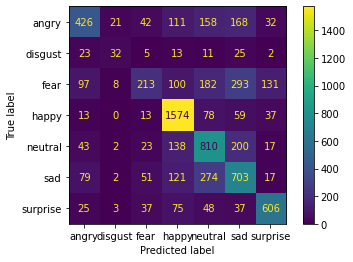

In [16]:
# Confusion Matrix
plot_confusion_matrix(y_true, ref_model_optimised_y_pred, classes)

In [34]:
# Calculate metrics
ref_model_optimised_precision, ref_model_optimised_recall, ref_model_optimised_fscore = calculate_model_metrics(y_true, ref_model_optimised_y_pred, classes)

              precision    recall  f1-score   support

       angry       0.53      0.47      0.50       479
     disgust       0.60      0.27      0.37        56
        fear       0.55      0.21      0.30       512
       happy       0.76      0.87      0.81       887
     neutral       0.48      0.68      0.56       617
         sad       0.50      0.48      0.49       624
    surprise       0.73      0.79      0.76       416

    accuracy                           0.60      3591
   macro avg       0.59      0.54      0.54      3591
weighted avg       0.60      0.60      0.58      3591

Precision: 0.592080666237283
Recall: 0.5383706417766557
F1 Score: 0.5414686341924702


<h2>Train model from optimised layers experiment</h2>

In [5]:
model_selection = Sequential()

# 1st layer
model_selection.add(Conv2D(96, (3,3), padding='same', input_shape=(48,48,1), activation='relu'))
model_selection.add(Conv2D(480, (3,3), padding='same', activation='relu'))
model_selection.add(BatchNormalization())
model_selection.add(MaxPooling2D(pool_size=(2,2)))
model_selection.add(Dropout(0.4))

# 2nd layer
model_selection.add(Conv2D(224, (3,3), padding='same', activation='relu'))
model_selection.add(BatchNormalization())
model_selection.add(MaxPooling2D(pool_size=(2,2)))
model_selection.add(Dropout(0.4))

# 3rd layer
model_selection.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model_selection.add(Conv2D(480, (3,3), padding='same', activation='relu'))
model_selection.add(BatchNormalization())
model_selection.add(MaxPooling2D(pool_size=(2,2)))
model_selection.add(Dropout(0.4))

#4th layer
model_selection.add(Conv2D(416, (3,3), padding='same', activation='relu'))
model_selection.add(BatchNormalization())
model_selection.add(MaxPooling2D(pool_size=(2,2)))
model_selection.add(Dropout(0.4))

# 5th layer
model_selection.add(Conv2D(480, (3,3), padding='same', activation='relu'))
model_selection.add(BatchNormalization())
model_selection.add(MaxPooling2D(pool_size=(2,2)))
model_selection.add(Dropout(0.4))

# Flatten and feed into dense layer
model_selection.add(Flatten())
model_selection.add(Dense(640, activation='relu'))
model_selection.add(BatchNormalization())
model_selection.add(Dropout(0.3))

model_selection.add(Dense(7, activation='softmax'))
model_selection.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

model_selection.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 96)        960       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 480)       415200    
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 480)      1920      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 480)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 480)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 224)       9

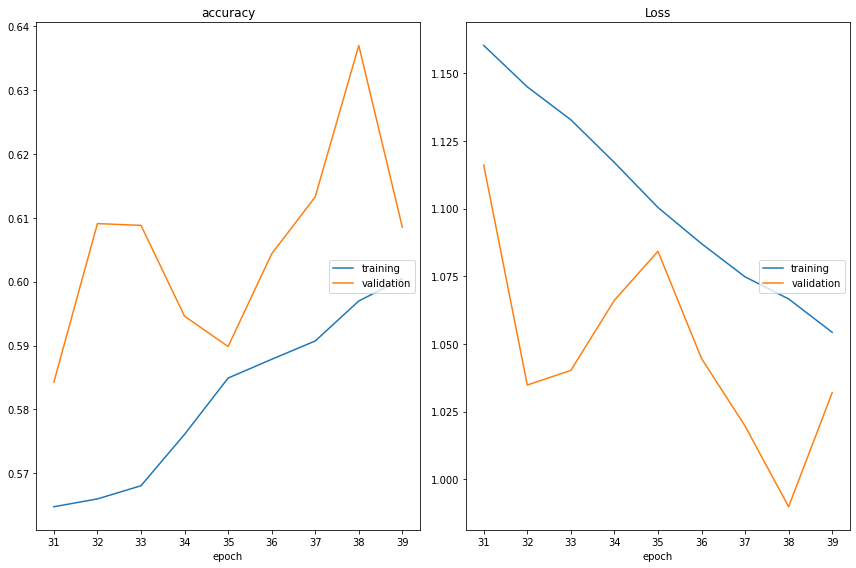

accuracy
	training         	 (min:    0.565, max:    0.600, cur:    0.600)
	validation       	 (min:    0.584, max:    0.637, cur:    0.609)
Loss
	training         	 (min:    1.054, max:    1.160, cur:    1.054)
	validation       	 (min:    0.990, max:    1.116, cur:    1.032)
224/224 [==============================] - 48s 216ms/step - loss: 1.0543 - accuracy: 0.6005 - val_loss: 1.0320 - val_accuracy: 0.6085


In [11]:
# Train model
epochs = 40

# Load model weights
model_selection.load_weights('weights/model_weights_selection_40.h5')

# Save model weights
checkpoint = ModelCheckpoint('weights/model_weights_selection_40.h5', monitor='val_accuracy', save_weights_only=True, mode='max', verbose=2)

# Train model
history_selection = model_selection.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    initial_epoch=31,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stop, PlotLossesKeras()],
)

In [28]:
# Test model
model_selection.load_weights('weights/model_weights_selection_40.h5')
model_selection_accuracy = model_selection.evaluate(test_generator)
model_selection_y_pred = model_selection.predict(test_generator)

29/29 [==============================] - 2s 62ms/step


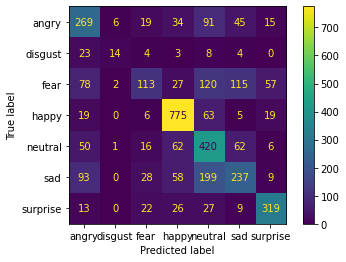

In [13]:
# Plot confusion matrix
cm = plot_confusion_matrix(y_true, model_selection_y_pred, classes)

In [29]:
# Calculate metrics
model_selection_precision, model_selection_recall, model_selection_fscore = calculate_model_metrics(y_true, model_selection_y_pred, classes)

              precision    recall  f1-score   support

       angry       0.49      0.56      0.53       479
     disgust       0.61      0.25      0.35        56
        fear       0.54      0.22      0.31       512
       happy       0.79      0.87      0.83       887
     neutral       0.45      0.68      0.54       617
         sad       0.50      0.38      0.43       624
    surprise       0.75      0.77      0.76       416

    accuracy                           0.60      3591
   macro avg       0.59      0.53      0.54      3591
weighted avg       0.60      0.60      0.58      3591

Precision: 0.5903392404505702
Recall: 0.5333384552962898
F1 Score: 0.5363612954060516


<h2>Model Selection with Hyperparameters Tuned 40 epoch</h2>

In [5]:
model_selection_tuned = Sequential()

# 1st layer
model_selection_tuned.add(Conv2D(96, (5,5), padding='same', input_shape=(48,48,1), activation='relu'))
model_selection_tuned.add(Conv2D(480, (5,5), padding='same', activation='relu', strides=2))
model_selection_tuned.add(BatchNormalization())
model_selection_tuned.add(MaxPooling2D(pool_size=(2,2)))
model_selection_tuned.add(Dropout(0.4))

# 2nd layer
model_selection_tuned.add(Conv2D(224, (3,3), padding='same', activation='relu'))
model_selection_tuned.add(BatchNormalization())
model_selection_tuned.add(MaxPooling2D(pool_size=(2,2)))
model_selection_tuned.add(Dropout(0.4))

# 3rd layer
model_selection_tuned.add(Conv2D(32, (3,3), padding='same', activation='relu', strides=2))
model_selection_tuned.add(Conv2D(480, (5,5), padding='same', activation='relu'))
model_selection_tuned.add(BatchNormalization())
model_selection_tuned.add(MaxPooling2D(pool_size=(2,2)))
model_selection_tuned.add(Dropout(0.4))

#4th layer
model_selection_tuned.add(Conv2D(416, (3,3), padding='same', activation='relu'))
model_selection_tuned.add(BatchNormalization())
model_selection_tuned.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model_selection_tuned.add(Dropout(0.4))

# 5th layer
model_selection_tuned.add(Conv2D(480, (5,5), padding='same', activation='relu', strides=2))
model_selection_tuned.add(BatchNormalization())
model_selection_tuned.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model_selection_tuned.add(Dropout(0.4))

# Flatten and feed into dense layer
model_selection_tuned.add(Flatten())
model_selection_tuned.add(Dense(640, activation='relu'))
model_selection_tuned.add(BatchNormalization())
model_selection_tuned.add(Dropout(0.3))

model_selection_tuned.add(Dense(7, activation='softmax'))
model_selection_tuned.compile(optimizer=RMSprop(learning_rate=0.001, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

model_selection_tuned.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 96)        2496      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 480)       1152480   
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 480)      1920      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 480)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 480)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 224)       9

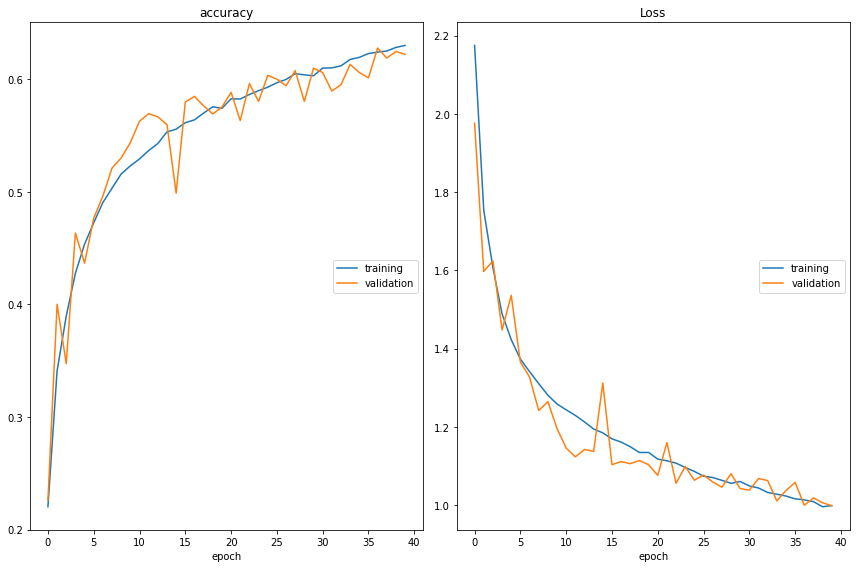

accuracy
	training         	 (min:    0.220, max:    0.630, cur:    0.630)
	validation       	 (min:    0.226, max:    0.628, cur:    0.622)
Loss
	training         	 (min:    0.996, max:    2.175, cur:    0.998)
	validation       	 (min:    0.998, max:    1.976, cur:    0.998)
224/224 [==============================] - 52s 233ms/step - loss: 0.9984 - accuracy: 0.6301 - val_loss: 0.9984 - val_accuracy: 0.6222 - lr: 0.0010


In [10]:
# Train model for 40 epoch
epochs = 40

# Load model weights
# model_selection_tuned.load_weights('weights/model_weights_selection_tuned_40.h5')

# Save model weights
checkpoint = ModelCheckpoint('weights/model_weights_selection_tuned_40.h5', monitor='val_accuracy', save_weights_only=True, mode='max', verbose=2)

# Train model
history_selection_tuned = model_selection_tuned.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    initial_epoch=0,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stop, PlotLossesKeras(), reduce_lr],
)

In [11]:
# Test model
model_selection_tuned.load_weights('weights/model_weights_selection_tuned_40.h5')
model_selection_tuned_accuracy = model_selection_tuned.evaluate(test_generator)
model_selection_tuned_y_pred = model_selection_tuned.predict(test_generator)

29/29 [==============================] - 2s 63ms/step


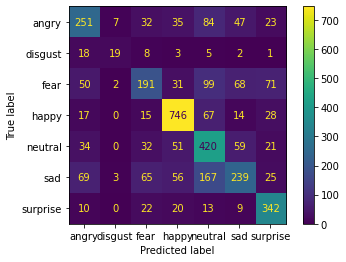

In [12]:
# Plot confusion matrix
cm = plot_confusion_matrix(y_true, model_selection_tuned_y_pred, classes)

In [13]:
# Calculate metrics
model_selection_tuned_precision, model_selection_tuned_recall, model_selection_tuned_fscore = calculate_model_metrics(y_true, model_selection_tuned_y_pred, classes)

              precision    recall  f1-score   support

       angry       0.56      0.52      0.54       479
     disgust       0.61      0.34      0.44        56
        fear       0.52      0.37      0.44       512
       happy       0.79      0.84      0.82       887
     neutral       0.49      0.68      0.57       617
         sad       0.55      0.38      0.45       624
    surprise       0.67      0.82      0.74       416

    accuracy                           0.61      3591
   macro avg       0.60      0.57      0.57      3591
weighted avg       0.61      0.61      0.60      3591

Precision: 0.5990441573161004
Recall: 0.5661742110345902
F1 Score: 0.5696660621056537


<h2>Compare Different Models Metrics</h2>

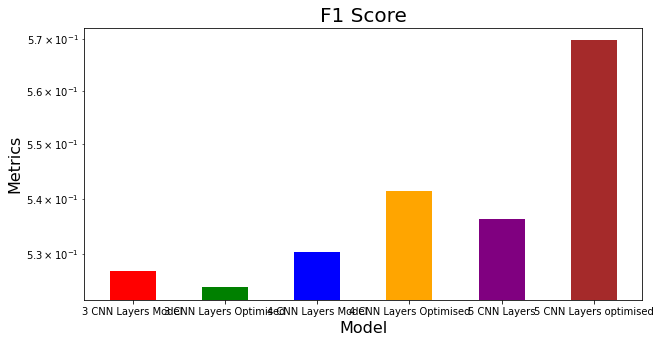

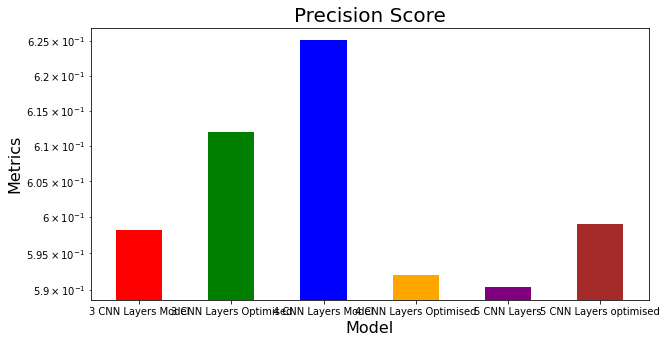

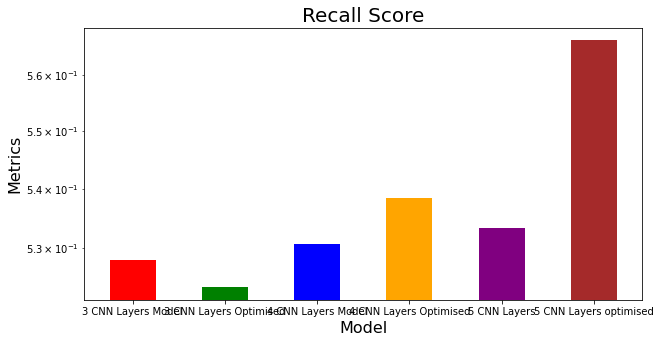

In [35]:
tick_labels = ['3 CNN Layers Model', '3 CNN Layers Optimised','4 CNN Layers Model', '4 CNN Layers Optimised', '5 CNN Layers', '5 CNN Layers optimised']
color=['red', 'green', 'blue', 'orange', 'purple', 'brown']
fscore_list = [first_model_fscore, first_model_optimised_fscore, ref_model_fscore, ref_model_optimised_fscore, model_selection_fscore, model_selection_tuned_fscore]
precision_list = [first_model_precision, first_model_optimised_precision, ref_model_precision, ref_model_optimised_precision, model_selection_precision, model_selection_tuned_precision]
recall_list = [first_model_recall, first_model_optimised_recall, ref_model_recall, ref_model_optimised_recall, model_selection_recall, model_selection_tuned_recall]

# Compare model metrics in a bar graph
plt.figure(facecolor='white', figsize=(10,5))
plt.title('F1 Score', fontsize=20)
plt.yscale('log')
plt.ylabel('Metrics', fontsize=16)
plt.xlabel('Model', fontsize=16)
plt.bar(np.arange(6), fscore_list, width=0.5, tick_label=tick_labels, color=color)
plt.savefig('graphs/f1_score.png')
plt.show()

plt.figure(facecolor='white', figsize=(10,5))
plt.title('Precision Score', fontsize=20)
plt.yscale('log')
plt.ylabel('Metrics', fontsize=16)
plt.xlabel('Model', fontsize=16)
plt.bar(np.arange(6), precision_list, width=0.5, tick_label=tick_labels, color=color)
plt.savefig('graphs/precision_score.png')
plt.show()

plt.figure(facecolor='white', figsize=(10,5))
plt.title('Recall Score', fontsize=20)
plt.yscale('log')
plt.ylabel('Metrics', fontsize=16)
plt.xlabel('Model', fontsize=16)
plt.bar(np.arange(6), recall_list, width=0.5, tick_label=tick_labels, color=color)
plt.savefig('graphs/recall_score.png')
plt.show()



<h2>4 CNN Layers Model run with 400 epoch<h2>

In [6]:
ref_model_optimised_400 = Sequential()

ref_model_optimised_400.add(Conv2D(256, (3,3), padding='same', input_shape=(48,48,1), activation='relu'))
ref_model_optimised_400.add(Conv2D(384, (3,3), padding='same', activation='relu'))
ref_model_optimised_400.add(BatchNormalization())
ref_model_optimised_400.add(MaxPooling2D(pool_size=(2,2)))
ref_model_optimised_400.add(Dropout(0.4))

ref_model_optimised_400.add(Conv2D(320, (3,3), padding='same', activation='relu'))
ref_model_optimised_400.add(BatchNormalization())
ref_model_optimised_400.add(MaxPooling2D(pool_size=(2,2)))
ref_model_optimised_400.add(Dropout(0.4))

ref_model_optimised_400.add(Conv2D(192, (3,3), padding='same', activation='relu'))
ref_model_optimised_400.add(BatchNormalization())
ref_model_optimised_400.add(MaxPooling2D(pool_size=(2,2)))
ref_model_optimised_400.add(Dropout(0.4))

ref_model_optimised_400.add(Conv2D(192, (3,3), padding='same', activation='relu'))
ref_model_optimised_400.add(BatchNormalization())
ref_model_optimised_400.add(MaxPooling2D(pool_size=(2,2)))
ref_model_optimised_400.add(Dropout(0.4))

ref_model_optimised_400.add(Flatten())
ref_model_optimised_400.add(Dense(352, activation='relu'))
ref_model_optimised_400.add(BatchNormalization())

ref_model_optimised_400.add(Dropout(0.4))
ref_model_optimised_400.add(Dense(7, activation='softmax'))

ref_model_optimised_400.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
ref_model_optimised_400.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 48, 48, 256)       2560      
                                                                 
 conv2d_8 (Conv2D)           (None, 48, 48, 384)       885120    
                                                                 
 batch_normalization_6 (Batc  (None, 48, 48, 384)      1536      
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24, 24, 384)      0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 384)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 320)      

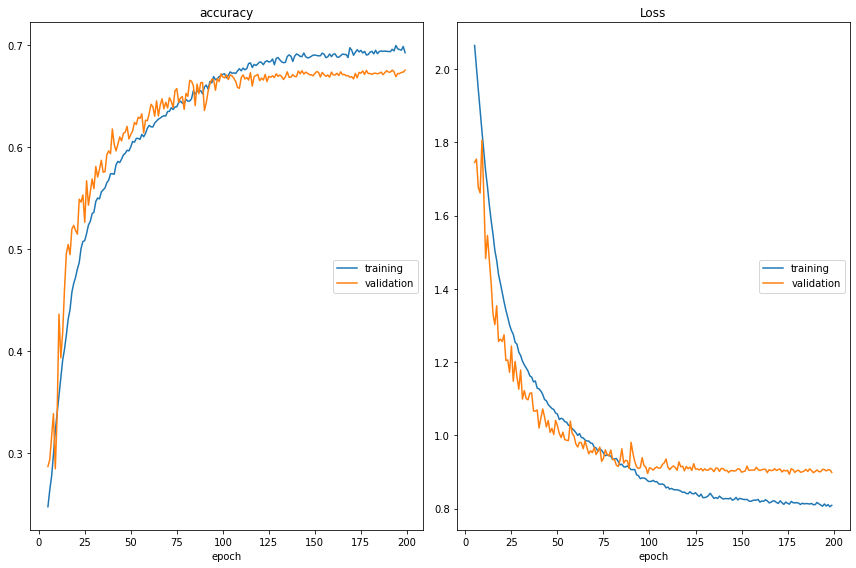

accuracy
	training         	 (min:    0.247, max:    0.700, cur:    0.693)
	validation       	 (min:    0.285, max:    0.676, cur:    0.676)
Loss
	training         	 (min:    0.805, max:    2.065, cur:    0.809)
	validation       	 (min:    0.894, max:    1.806, cur:    0.899)
224/224 [==============================] - 51s 228ms/step - loss: 0.8091 - accuracy: 0.6929 - val_loss: 0.8990 - val_accuracy: 0.6758 - lr: 1.0000e-05


In [33]:
# Train ref model optimised 400 epoch
# Train model
epochs = 200

# Load model weights
model = ref_model_optimised_400.load_weights('weights/model_weights_ref_optimised_400.h5')

# Save model weights
checkpoint = ModelCheckpoint('weights/model_weights_ref_optimised_400.h5', monitor='val_accuracy', save_weights_only=True, mode='max', verbose=2)

history_ref_optimised_400 = ref_model_optimised_400.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    initial_epoch=5,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stop, PlotLossesKeras(), reduce_lr],
)


In [7]:
# Evaluate Model
ref_model_optimised_400.load_weights('weights/model_weights_ref_optimised_400.h5')
ref_model_optimised_400.evaluate(test_generator)
y_pred = ref_model_optimised_400.predict(test_generator, test_generator.n//test_generator.batch_size+1)

# Save the model
# ref_model_optimised_400.save('ref_model_optimised_400.h5')

29/29 [==============================] - 3s 75ms/step


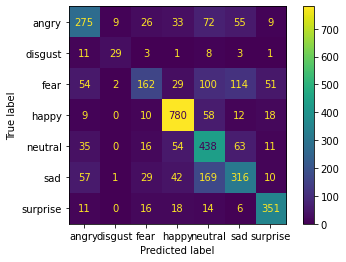

In [8]:
# Confusion Matrix
plot_confusion_matrix(y_true, y_pred, classes)

In [9]:
# Calculate metrics
ref_model_optimised_400_precision, ref_model_optimised_400_recall, ref_model_optimised_400_fscore = calculate_model_metrics(y_true, y_pred, classes)

              precision    recall  f1-score   support

       angry       0.61      0.57      0.59       479
     disgust       0.71      0.52      0.60        56
        fear       0.62      0.32      0.42       512
       happy       0.82      0.88      0.85       887
     neutral       0.51      0.71      0.59       617
         sad       0.56      0.51      0.53       624
    surprise       0.78      0.84      0.81       416

    accuracy                           0.65      3591
   macro avg       0.66      0.62      0.63      3591
weighted avg       0.66      0.65      0.64      3591

Precision: 0.6560882576612003
Recall: 0.6211130843346845
F1 Score: 0.6266048332514034


<h2>Model Selection high epoch</h2>

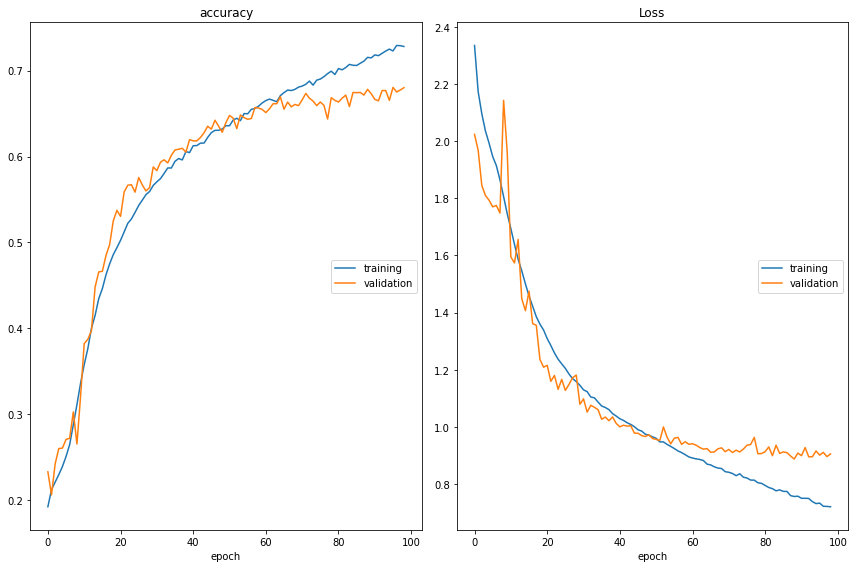

accuracy
	training         	 (min:    0.192, max:    0.729, cur:    0.728)
	validation       	 (min:    0.206, max:    0.681, cur:    0.680)
Loss
	training         	 (min:    0.720, max:    2.335, cur:    0.720)
	validation       	 (min:    0.887, max:    2.143, cur:    0.905)
224/224 [==============================] - 80s 356ms/step - loss: 0.7204 - accuracy: 0.7282 - val_loss: 0.9051 - val_accuracy: 0.6802
Epoch 99: early stopping


In [ ]:
epoch = 150

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.00001, mode='auto')

model_selection_checkpoint = ModelCheckpoint('weights/model_weights_selection_40.h5', monitor='val_accuracy', save_weights_only=True, mode='max', verbose=2)

history_model_selection = model_selection.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[model_selection_checkpoint, early_stop, PlotLossesKeras()],
)

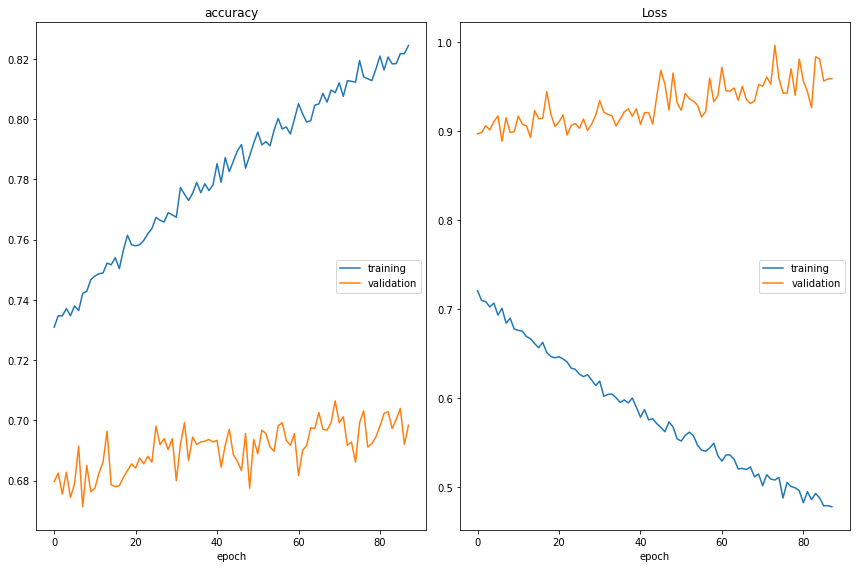

accuracy
	training         	 (min:    0.731, max:    0.824, cur:    0.824)
	validation       	 (min:    0.671, max:    0.706, cur:    0.698)
Loss
	training         	 (min:    0.478, max:    0.721, cur:    0.478)
	validation       	 (min:    0.889, max:    0.997, cur:    0.959)
224/224 [==============================] - 112s 499ms/step - loss: 0.4775 - accuracy: 0.8244 - val_loss: 0.9593 - val_accuracy: 0.6984
Epoch 89/400
 50/224 [=====>........................] - ETA: 1:24 - loss: 0.4675 - accuracy: 0.8280

KeyboardInterrupt: 

In [ ]:
# Train extra 50 times without early stop
# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.00001, mode='auto')

# Stop training when val loss has stopped improving
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=1)

model_selection_checkpoint = ModelCheckpoint('weights/model_weights_selection.h5', monitor='val_accuracy', save_weights_only=True, mode='max', verbose=2)

history_model_selection = model_selection.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[model_selection_checkpoint, PlotLossesKeras()],
)

In [7]:
model_selection.load_weights('weights/model_weights_selection.h5')
model_selection.evaluate(test_generator)
model_selection_y_pred = model_selection.predict(test_generator, test_generator.n//test_generator.batch_size+1)

# Save the model
model_selection.save('model_selection.h5')

29/29 [==============================] - 2s 60ms/step


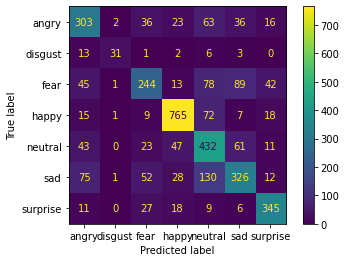

In [12]:
# Confusion Matrix
plot_confusion_matrix(y_true, model_selection_y_pred, classes)

In [13]:
# Calculate metrics
model_selection_precision, model_selection_recall, model_selection_fscore = calculate_model_metrics(y_true, model_selection_y_pred, classes)

              precision    recall  f1-score   support

       angry       0.60      0.63      0.62       479
     disgust       0.86      0.55      0.67        56
        fear       0.62      0.48      0.54       512
       happy       0.85      0.86      0.86       887
     neutral       0.55      0.70      0.61       617
         sad       0.62      0.52      0.57       624
    surprise       0.78      0.83      0.80       416

    accuracy                           0.68      3591
   macro avg       0.70      0.65      0.67      3591
weighted avg       0.68      0.68      0.68      3591

Precision: 0.6969487780070479
Recall: 0.653869199426578
F1 Score: 0.667152046816529


<h2>Run model selection with hyperparameter tuned</h2>

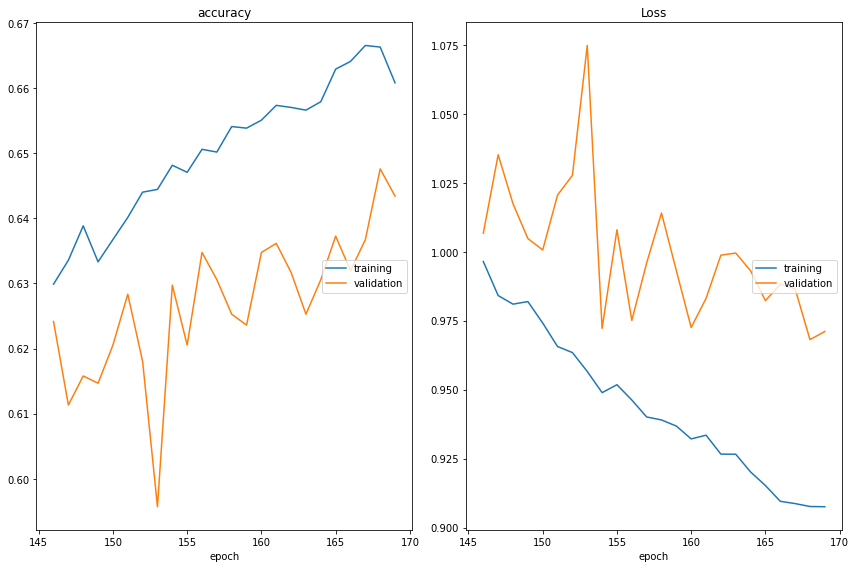

accuracy
	training         	 (min:    0.630, max:    0.667, cur:    0.661)
	validation       	 (min:    0.596, max:    0.648, cur:    0.643)
Loss
	training         	 (min:    0.908, max:    0.996, cur:    0.908)
	validation       	 (min:    0.968, max:    1.075, cur:    0.971)
224/224 [==============================] - 51s 226ms/step - loss: 0.9075 - accuracy: 0.6608 - val_loss: 0.9711 - val_accuracy: 0.6434 - lr: 0.0010


In [6]:
epoch = 170

# Load weights
model_selection_tuned.load_weights('weights/model_weights_selection_tuned_40.h5')

model_selection_tuned_checkpoint = ModelCheckpoint('weights/model_weights_selection_tuned.h5', monitor='val_accuracy', save_weights_only=True, mode='max', verbose=2)

history_model_selection_tuned = model_selection_tuned.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epoch,
    initial_epoch=146,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[model_selection_tuned_checkpoint, early_stop, PlotLossesKeras(), reduce_lr],
)

In [15]:
# Evaluate Model
model_selection_tuned.load_weights('weights/model_weights_selection_tuned.h5')
model_selection_tuned.evaluate(test_generator)
model_selection_tuned_y_pred = model_selection_tuned.predict(test_generator, test_generator.n//test_generator.batch_size+1)

29/29 [==============================] - 2s 65ms/step


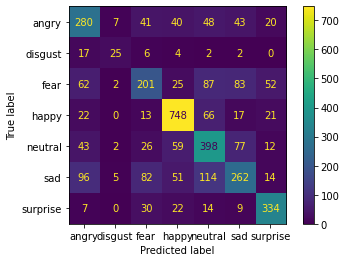

In [16]:
# Plot confusion matrix
plot_confusion_matrix(y_true, model_selection_tuned_y_pred, classes)

In [17]:
# Calculate metrics
model_selection_tuned_precision, model_selection_tuned_recall, model_selection_tuned_fscore = calculate_model_metrics(y_true, model_selection_tuned_y_pred, classes)

              precision    recall  f1-score   support

       angry       0.53      0.58      0.56       479
     disgust       0.61      0.45      0.52        56
        fear       0.50      0.39      0.44       512
       happy       0.79      0.84      0.81       887
     neutral       0.55      0.65      0.59       617
         sad       0.53      0.42      0.47       624
    surprise       0.74      0.80      0.77       416

    accuracy                           0.63      3591
   macro avg       0.61      0.59      0.59      3591
weighted avg       0.62      0.63      0.62      3591

Precision: 0.6068176090776592
Recall: 0.5906661394992673
F1 Score: 0.5939153317872456


<h2>Compare the 2 model with high epoch training till val acc stabilise</h2>

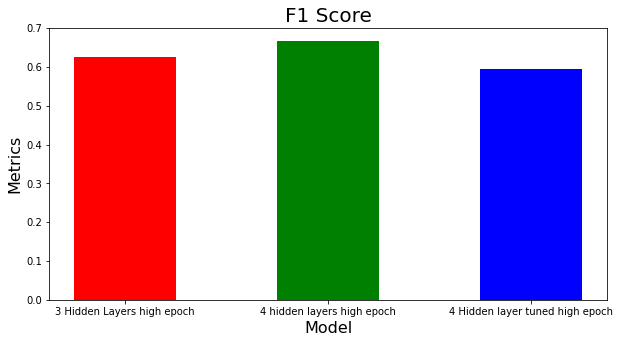

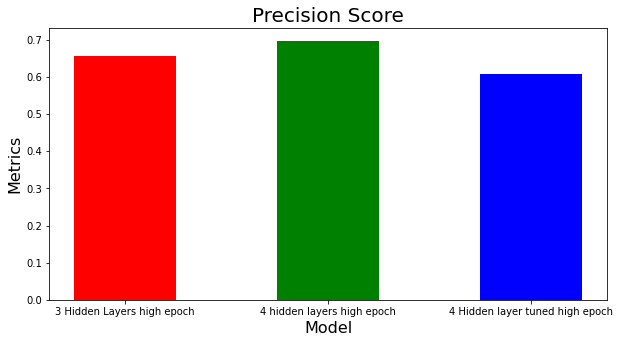

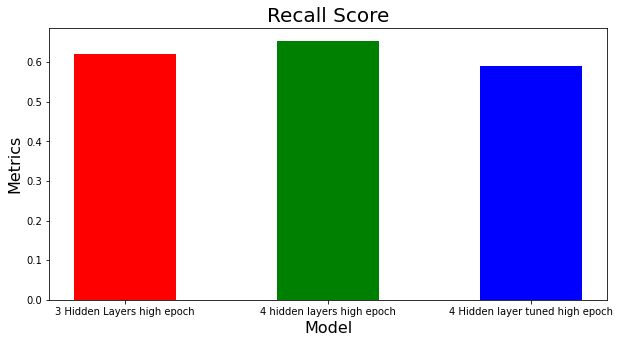

In [18]:
tick_labels = ['3 Hidden Layers high epoch', '4 hidden layers high epoch', '4 Hidden layer tuned high epoch']
color=['red', 'green', 'blue']
fscore_list = [ref_model_optimised_400_fscore, model_selection_fscore, model_selection_tuned_fscore]
precision_list = [ref_model_optimised_400_precision, model_selection_precision, model_selection_tuned_precision]
recall_list = [ref_model_optimised_400_recall, model_selection_recall, model_selection_tuned_recall]

# Compare model metrics in a bar graph
plt.figure(facecolor='white', figsize=(10,5))
plt.title('F1 Score', fontsize=20)
#
plt.ylabel('Metrics', fontsize=16)
plt.xlabel('Model', fontsize=16)
plt.bar(np.arange(3), fscore_list, width=0.5, tick_label=tick_labels, color=color)
plt.savefig('graphs/f1_score_high_epoch.png')
plt.show()

plt.figure(facecolor='white', figsize=(10,5))
plt.title('Precision Score', fontsize=20)
# plt.yscale('log')
plt.ylabel('Metrics', fontsize=16)
plt.xlabel('Model', fontsize=16)
plt.bar(np.arange(3), precision_list, width=0.5, tick_label=tick_labels, color=color)
plt.savefig('graphs/precision_score_high_epoch.png')
plt.show()

plt.figure(facecolor='white', figsize=(10,5))
plt.title('Recall Score', fontsize=20)
# plt.yscale('log')
plt.ylabel('Metrics', fontsize=16)
plt.xlabel('Model', fontsize=16)
plt.bar(np.arange(3), recall_list, width=0.5, tick_label=tick_labels, color=color)
plt.savefig('graphs/recall_score_high_epoch.png')
plt.show()